In [57]:
import pydicom as dicom # read the dicom files
import os # do directory operations
import pandas as pd # nice for data analysis

In [58]:
# /home/nuno/Downloads/datasets/kaggle-lung_cancer_2017
# /media/nuno/LaCie02/NUNO/datasets/stage1

data_dir = '/media/nuno/LaCie02/NUNO/datasets/stage1/'
patients = os.listdir(data_dir)
labels_df = pd.read_csv('/home/nuno/Downloads/datasets/kaggle-lung_cancer_2017/stage1_labels.csv', index_col=0)


In [59]:
labels_df.head()

,cancer
id,
0015ceb851d7251b8f399e39779d1e7d,1
0030a160d58723ff36d73f41b170ec21,0
003f41c78e6acfa92430a057ac0b306e,0
006b96310a37b36cccb2ab48d10b49a3,1
008464bb8521d09a42985dd8add3d0d2,1


In [60]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer') # the label of cancer/no cancer for one patient
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    print(len(slices), slices[0].pixel_array.shape)
    #print(slices[0])
    

/home/nuno/envs/tf_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


195 (512, 512)


In [61]:
len(patients) # number of patients

1596

In [62]:
import matplotlib.pyplot as plt    

/home/nuno/envs/tf_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/nuno/envs/tf_gpu/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


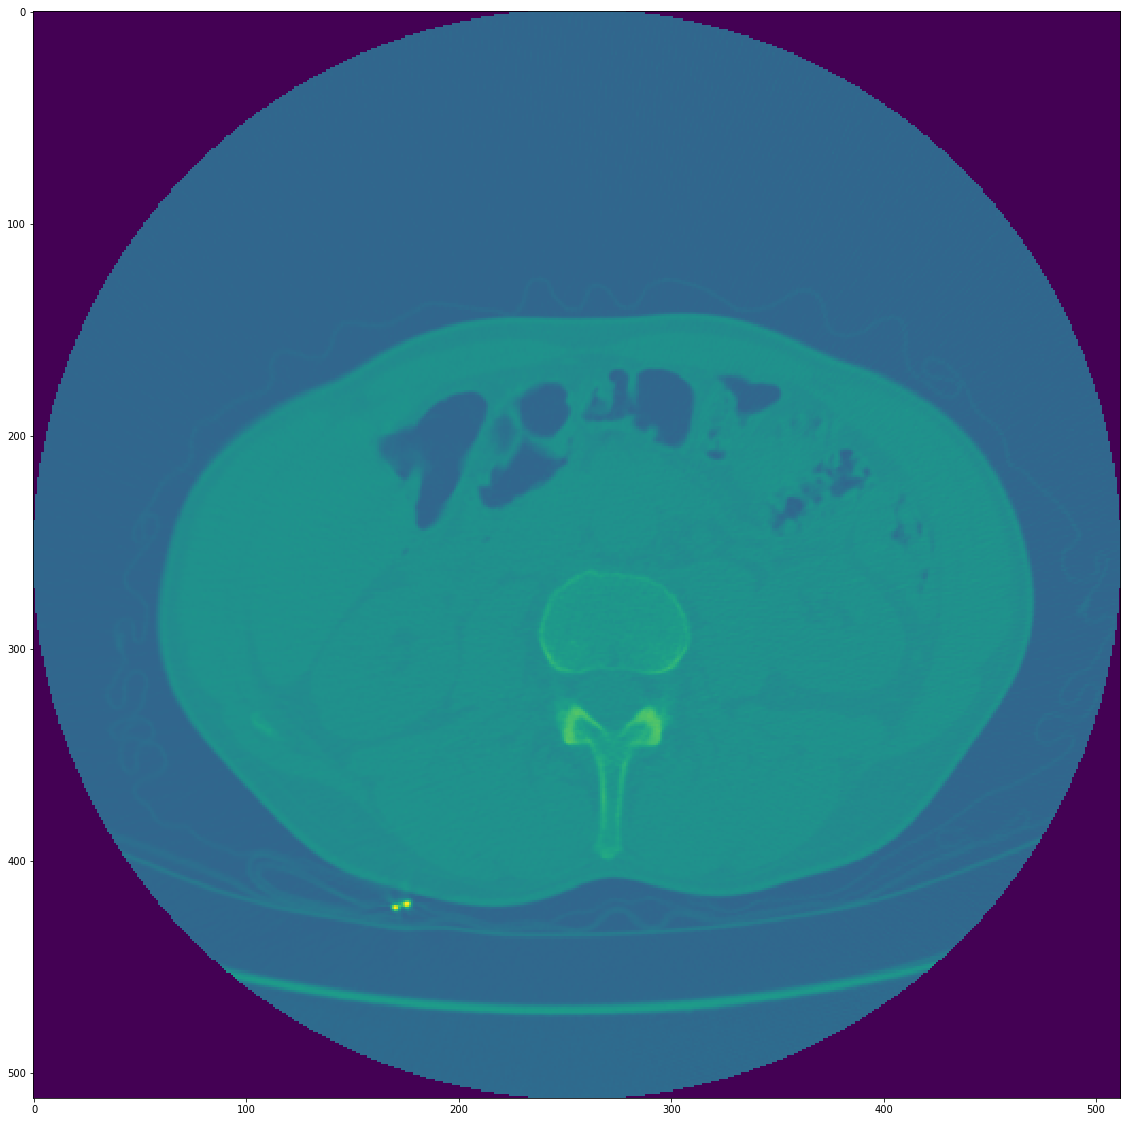

In [63]:
for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer') # the label of cancer/no cancer for one patient
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # sorting the slices in the proper order
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) 
    plt.imshow(slices[0].pixel_array)
    plt.show()

# This is to increase the size of the images

In [64]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 30, 20  # that's default image size for this interactive session
pylab.rcParams['font.family'] = 'sans-serif'
pylab.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
pylab.rcParams['font.serif'] = ['Bitstream Vera Sans']
pylab.rcParams["font.size"] = "10"

# View different slices in sub plot

/home/nuno/envs/tf_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:8: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/home/nuno/envs/tf_gpu/lib/python3.5/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


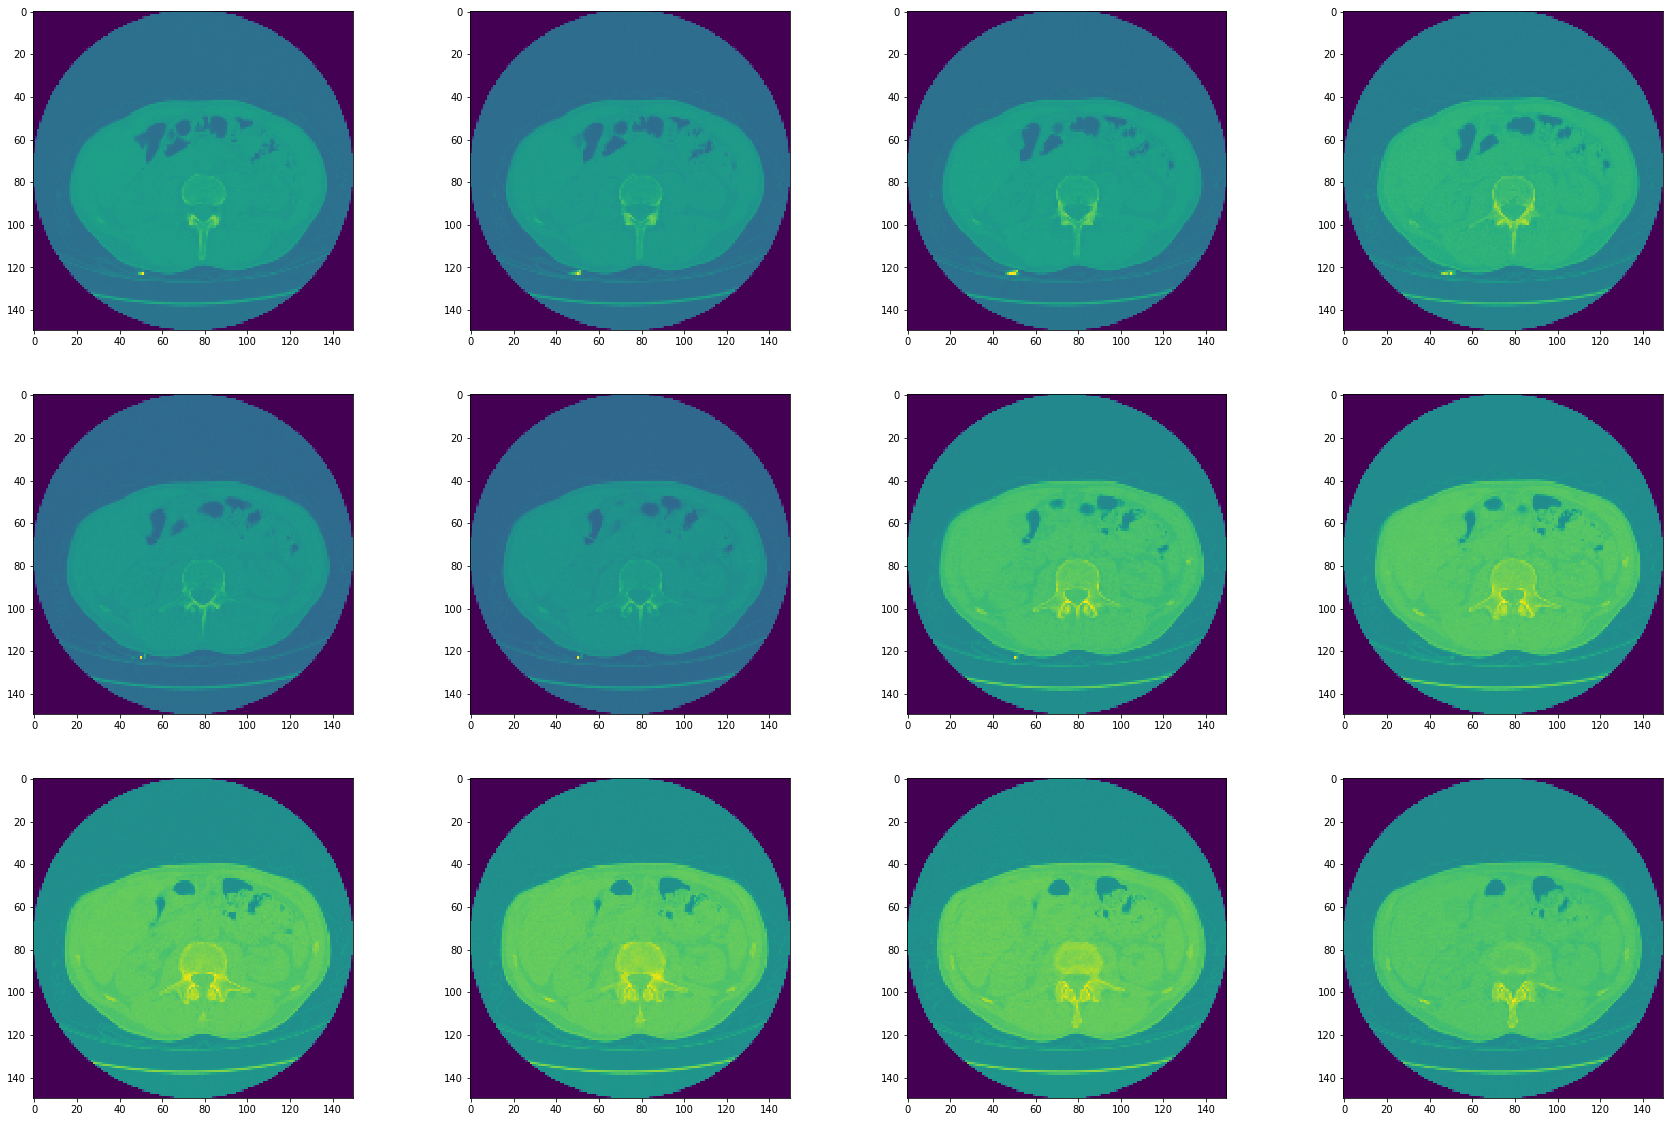

In [65]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

IMG_PX = 150

for patient in patients[:1]:
    label = labels_df.get_value(patient, 'cancer') # the label of cancer/no cancer for one patient
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # sorting the slices in the proper order
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) 
    
    fig = plt.figure()
    for num, each_slice in enumerate(slices[:12]):
        y = fig.add_subplot(3,4, num+1)
        new_image = cv2.resize(np.array(each_slice.pixel_array), (IMG_PX, IMG_PX))
        
        y.imshow(new_image)
    
    plt.show()
        

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

IMG_PX = 150
HM_SLICES = 20


def chunks(l, n):
    """Yield successive n-size chunks from l"""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def mean(l):
    return sum(l)/len(l)
    

for patient in patients[:10]:
    label = labels_df.get_value(patient, 'cancer') # the label of cancer/no cancer for one patient
    path = data_dir + patient
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    # sorting the slices in the proper order
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2])) 
    
    new_slices = []
    # resize all slices inside slices
    slices = [cv2.resize(np.array(each_slice.pixel_array), (IMG_PX, IMG_PX)) for each_slice in slices]
    
    # size of the chunk which will be length of slices divide by HM_SLICES
    chunk_size = math.ceil(len(slices) / HM_SLICES)
    
    # this is averaging the slice_chunk in order to transform into one slice
    # and then adding all average slices to the new_slices
    # making new_slices a new image of the patient lungs (smaller data - 
    # more averaging - but now all will have the same size)
    for slice_chunk in chunks(slices, chunk_size):
        slice_chunk = list(map(mean, zip(*slice_chunk)))
        new_slices.append(slice_chunk)

    ## for all the cases that we don't get 20 slices
    # repeat the last one if there are 19
    if len(new_slices) == HM_SLICES - 1:
        new_slices.append(new_slices[-1])
    
    # repeat the last one two time if there are 18
    if len(new_slices) == HM_SLICES - 2:
        new_slices.append(new_slices[-1])
        new_slices.append(new_slices[-1])
    
    # there are 22; the final 2 slices we are going to average them together
    if len(new_slices) == HM_SLICES + 2:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        # delete the last slice and add the new avergare of the last two
        # as the new last slice
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val
                                       
    # do the same thing as in the 22 cases
    if len(new_slices) == HM_SLICES + 1:
        new_val = list(map(mean, zip(*[new_slices[HM_SLICES-1], new_slices[HM_SLICES]])))
        # delete the last slice and add the new avergare of the last two
        # as the new last slice
        del new_slices[HM_SLICES]
        new_slices[HM_SLICES-1] = new_val

    print(len(new_slices))
    
#     fig = plt.figure()
#     for num, each_slice in enumerate(slices[:12]):
#         y = fig.add_subplot(3,4, num+1)
#         new_image = cv2.resize(np.array(each_slice.pixel_array), (IMG_PX, IMG_PX))
        
#         y.imshow(new_image)
    
#     plt.show()
        

/home/nuno/envs/tf_gpu/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: get_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


20
20
20
